# Overview
We're going to load already played chess games and add extra analytics to the games. 
- Games will come from Lichess because it's FOSS (Free and open source software) 
    - We'll use the Lichess "Elite Database" https://lichess.org/team/lichess-elite-database
- Analytics like: blunders, mistakes, and inaccuracies. And then show you how to get data to do analytics based on Elo advantage and openings.

In [168]:
import chess#https://github.com/niklasf/python-chess
from stockfish import Stockfish

#We'll create an intentionally worse stockfish engine to estimate complexity of positions
stockfish_good=Stockfish("stockfish_14_x64_avx2.exe")
stockfish_good.set_depth(20)#How deep the AI looks
stockfish_good.set_skill_level(20)#Highest rank stockfish
stockfish_bad=Stockfish("stockfish_14_x64_avx2.exe")
stockfish_bad.set_depth(3)
stockfish_bad.set_skill_level(3)


In [169]:
import chess.pgn
import pandas as pd
pd.options.display.max_columns=999
import datetime
import tqdm
import zipfile

# Process PGN into Python Friendlier Form

In [4]:
NUM_GAMES=366392#from https://database.nikonoel.fr/ Not necessary but helpful to get tqdm to give estimate
rows=[]
with open(f'data/lichess_elite_2022-03.pgn') as pgn:
    for game in tqdm.tqdm(range(NUM_GAMES)):
        row={}
        game = chess.pgn.read_game(pgn)
        row['headers']=game.headers.__dict__
        row['moves']=[x.uci() for x in game.mainline_moves()]
        rows.append(row)
games=pd.DataFrame(rows)
games

  0%|▌                                                                                                                                                                                             | 1140/366392 [00:03<16:17, 373.52it/s]


KeyboardInterrupt: 

In [5]:
#Save as CSV for easy, faster access
games.to_csv("data/loaded_games.csv",index=False)

Loading a big PGN file is a little slow. There are more advanced coding architectures meant to handle that since sometimes the data creation rate is faster than you can process on one machine. Essentially you would do stream processing with scalable worker nodes. Another optimation would be multi-threading since there is a lot of I/O (input output) but multi-processing may work well too. Since 20 minutes isn't the end of the world we will just wait for now.  
  
Let me know if you'd like a tutorial on any of that and I'll prioritize putting one together.


# Game Analysis
As mentioned in the intro we want to run through these games to add extra analytics such as: 
- position complexity (count blunders by player, average complexity)
- openings used
- win rates by Elo rating and openings

In [170]:
games=pd.read_csv("data/loaded_games.csv")
games

,headers,moves,index
0,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['e2e4', 'd7d5', 'e4d5', 'd8d5', 'b1c3', 'd5d6...",6561
1,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['d2d4', 'g7g6', 'c2c4', 'f8g7', 'b1c3', 'g8f6...",6562
2,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['e2e4', 'e7e5', 'g1f3', 'b8c6', 'f1b5', 'a7a6...",6563
3,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['f2f4', 'd7d5', 'g1f3', 'g7g6', 'e2e3', 'f8g7...",6564
4,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['d2d4', 'g8f6', 'g1f3', 'g7g6', 'c2c4', 'f8g7...",6565
...,...,...,...
366387,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['e2e4', 'c7c6', 'g1f3', 'd7d5', 'b1c3', 'c8g4...",372948
366388,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['d2d4', 'g8f6', 'b1c3', 'd7d5', 'c1f4', 'e7e6...",372949
366389,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['d2d4', 'g8f6', 'g1f3', 'd7d5', 'c1f4', 'c7c6...",372950
366390,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","['d2d4', 'g8f6', 'c2c4', 'g7g6', 'b1c3', 'd7d5...",372951


In [171]:
#Convert moves from string into list of move strings 

#Try not to run eval unless you really need to and are sure the text comes from a trusted source
games['moves']=games['moves'].apply(lambda x: eval(x))
games['headers']=games['headers'].apply(lambda x: eval(x))#to dict

In [172]:
game=games.iloc[0]
game['headers']

{'_tag_roster': {'Event': 'Rated Blitz game',
  'Site': '?',
  'Date': '2022.03.01',
  'Round': '-',
  'White': 'cheesman_css',
  'Black': 'RCordero',
  'Result': '0-1'},
 '_others': {'LichessURL': 'https://lichess.org/WbgBrAHb',
  'WhiteElo': '2665',
  'BlackElo': '2742',
  'ECO': 'B01',
  'Opening': 'Scandinavian Defense: Gubinsky-Melts Defense',
  'TimeControl': '180+0',
  'UTCDate': '2022.03.01',
  'UTCTime': '00:00:34',
  'Termination': 'Normal',
  'WhiteRatingDiff': '-5',
  'BlackRatingDiff': '+5'}}

## Grab Interesting Variables
We're going to parse out specific data points from headers and moves. Anything interesting we will store as a top-level column on the dataframe so when we ultimately store this data it's ready to go for analysis.

If you just want everything from headers you can use pd.json_normalize 

In [173]:
games['lichess_id']=games['headers'].apply(lambda x: x.get("_others",{}).get("LichessURL","").split("/")[-1])
games['ECO']=games['headers'].apply(lambda x: x.get("_others",{}).get("ECO"))
games['white_elo']=games['headers'].apply(lambda x: x.get("_others",{}).get("WhiteElo","").split("-")[0]).astype(int)
games['black_elo']=games['headers'].apply(lambda x: x.get("_others",{}).get("BlackElo","").split("-")[0]).astype(int)
games['opening_name']=games['headers'].apply(lambda x: x.get("_others",{}).get("Opening",""))

games['white_score']=games['headers'].apply(lambda x: x.get("_tag_roster",{}).get("Result","").split("-")[0].replace("1/2",".5")).astype(float)
games

,headers,moves,index,lichess_id,ECO,white_elo,black_elo,opening_name,white_score
0,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[e2e4, d7d5, e4d5, d8d5, b1c3, d5d6, d2d4, g8f...",6561,WbgBrAHb,B01,2665,2742,Scandinavian Defense: Gubinsky-Melts Defense,0.0
1,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[d2d4, g7g6, c2c4, f8g7, b1c3, g8f6, e2e4, e8g...",6562,xDtYtgJ8,E70,2509,2479,King's Indian Defense: Normal Variation,0.0
2,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5a4, g8f...",6563,WTfqUqiM,C88,2558,2536,Ruy Lopez: Closed,1.0
3,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[f2f4, d7d5, g1f3, g7g6, e2e3, f8g7, b1c3, g8h...",6564,UOl2a0HM,A03,2393,2530,Bird Opening: Dutch Variation,0.0
4,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[d2d4, g8f6, g1f3, g7g6, c2c4, f8g7, b1c3, d7d...",6565,ipDCA2PX,D91,2586,2691,"GrÃ¼nfeld Defense: Three Knights Variation, Pe...",1.0
...,...,...,...,...,...,...,...,...,...
366387,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[e2e4, c7c6, g1f3, d7d5, b1c3, c8g4, h2h3, g4f...",372948,FzECmQ52,B11,2463,2538,"Caro-Kann Defense: Two Knights Attack, Mindeno...",0.0
366388,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[d2d4, g8f6, b1c3, d7d5, c1f4, e7e6, f2f3, a7a...",372949,7iM8AJsS,D01,2551,2638,Rapport-Jobava System,0.0
366389,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[d2d4, g8f6, g1f3, d7d5, c1f4, c7c6, e2e3, c8g...",372950,mgOPIhaI,D02,2529,2413,Queen's Pawn Game: London System,0.0
366390,"{'_tag_roster': {'Event': 'Rated Blitz game', ...","[d2d4, g8f6, c2c4, g7g6, b1c3, d7d5, c4d5, f6d...",372951,CPdjB0ji,D85,2712,2587,GrÃ¼nfeld Defense: Exchange Variation,1.0


Data looks mostly good but I noticed "GrÃ¼nfeld Defense: Exchange Variation" showing up funky. We can use ftfy to fix this.

In [174]:
#If you get an error on this import be sure to run pip install ftfy==6.1.1. This was added to requirements.txt recently
import ftfy
ftfy.fix_encoding("GrÃ¼nfeld Defense: Exchange Variation")

'Grünfeld Defense: Exchange Variation'

In [175]:
#Can run shell commands directly in Jupyter using !. Run below if you are curious or had an import error above
!pip install ftfy==6.1.1

In [176]:
games['opening_name']=games['opening_name'].apply(ftfy.fix_encoding)
games['opening_name']

0              Scandinavian Defense: Gubinsky-Melts Defense
1                   King's Indian Defense: Normal Variation
2                                         Ruy Lopez: Closed
3                             Bird Opening: Dutch Variation
4         Grünfeld Defense: Three Knights Variation, Pet...
                                ...                        
366387    Caro-Kann Defense: Two Knights Attack, Mindeno...
366388                                Rapport-Jobava System
366389                     Queen's Pawn Game: London System
366390                 Grünfeld Defense: Exchange Variation
366391                                    Zukertort Opening
Name: opening_name, Length: 366392, dtype: object

Opening name looks good now!

In [177]:
#Ensure score parsed correctly
games['white_score'].value_counts()

1.0    174730
0.0    157257
0.5     34405
Name: white_score, dtype: int64

# Quick Analysis
How does well does a higher Elo correlate with winning?

In [178]:
import scipy.stats as stats
games['white_elo_advantage']=games['white_elo']-games['black_elo']

#A quick google suggests point-biserial correlation is better than pd.DataFrame.corr but I found the same results both ways. 
#Pandas does not return p-value so we will use scipy.stats
stats.pointbiserialr(games['white_elo_advantage'], games['white_score'])

PointbiserialrResult(correlation=0.2841701321375395, pvalue=0.0)

.284 is a relativbely weak correlation but I'm glad to see it's positive. Positive means an increase in Elo for white correlates with a higher win chance.  
  
The pvalue of 0 implies the result is significant. In practice we need to be careful assigning too much importance to p-value in generalizing our results to other game sets and Elos. It is possible our dataset is biased in some way and that should always inform how much you trust your results

# Running Stored Game


In [179]:
#Standard point values for different pieces. Lowercase is white piece and uppercase is black
piece_scores={
    "p": 1,
    "P": -1,
    "r": 5,
    "R": -5,
    "n": 3,
    "N": -3,
    "b": 3,
    "B": -3,
    "q": 9,
    "Q": -9
}

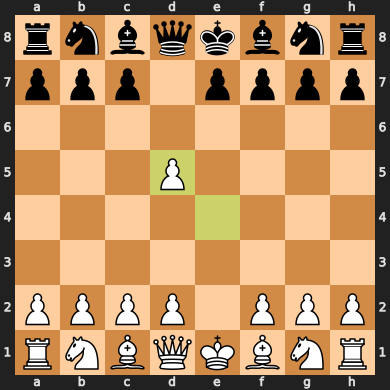

In [181]:
#Play a game up to move number

move_number=3
row={}
row['taken']=[]
board=chess.Board()
for san in game['moves'][:move_number]:
    parsed_san=board.parse_san(san)#move by the san "Standard Algebraic Notation"
    taken=board.piece_at(parsed_san.to_square)
    if taken:
        row['taken'].append(taken.__str__())
    move=board.push_san(san)
board

All we have to do is iterate through moves. For [chessnit.com](http://www.chessnit.com) I was looking at specific positions so I simply chose a random number to evaluate in each game.

In [183]:
import random

#Used by chessnit.com
def build_stored_game_analysis(game, move_number):
    row={}
    row['move_number']=move_number
    row['taken']=[]
    board=chess.Board()
    for san in game['moves'][:move_number]:
        parsed_san=board.parse_san(san)
        taken=board.piece_at(parsed_san.to_square)
        if taken:
            row['taken'].append(taken.__str__())
        move=board.push_san(san)
    row['invalid']=bool(board.promoted) or bool(board.outcome())
    stockfish_good.set_fen_position(board.fen())
    evaluation=stockfish_good.get_evaluation()
    row['evaluation']=evaluation['value']
    
    
    row['taken_score']=sum([piece_scores.get(p) for p in row['taken']])*100
    row['fen']=board.fen()
    row['url']=game['headers'].get("_others",{}).get("LichessURL","")+f"#{move_number}"
    try:
        row['last_move']=san
    except:
        print(game)
        row['invalid']=True
    return row
row=build_stored_game_analysis(game, 20)
row

{'move_number': 20,
 'taken': ['p', 'P'],
 'invalid': False,
 'evaluation': -292,
 'taken_score': 0,
 'fen': 'r2qkb1r/pp2pppp/1np2n2/8/2NP1Bb1/2N2Q2/PPP2PPP/2KR1B1R w kq - 10 11',
 'url': 'https://lichess.org/WbgBrAHb#20',
 'last_move': 'c8g4'}

In [185]:
#Look at the URL and compare against our evaluation
print(row['url'])

https://lichess.org/WbgBrAHb#20


The most interesting games from a positional point of view are when the simple score by taken pieces and the evaluation differ.    
And it's most interesting to find the first move when that difference grew large enough to be notable. 2.92 is surely a notable score.

In [186]:
rows=[]
for move_number in tqdm.tqdm(range(1,20+1)):
    rows.append(build_stored_game_analysis(game, move_number))
moves=pd.DataFrame(rows).set_index("move_number")
moves

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.90s/it]


,taken,invalid,evaluation,taken_score,fen,url,last_move
move_number,,,,,,,
1,[],False,33,0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,https://lichess.org/WbgBrAHb#1,e2e4
2,[],False,86,0,rnbqkbnr/ppp1pppp/8/3p4/4P3/8/PPPP1PPP/RNBQKBN...,https://lichess.org/WbgBrAHb#2,d7d5
3,[p],False,92,100,rnbqkbnr/ppp1pppp/8/3P4/8/8/PPPP1PPP/RNBQKBNR ...,https://lichess.org/WbgBrAHb#3,e4d5
4,"[p, P]",False,75,0,rnb1kbnr/ppp1pppp/8/3q4/8/8/PPPP1PPP/RNBQKBNR ...,https://lichess.org/WbgBrAHb#4,d8d5
5,"[p, P]",False,80,0,rnb1kbnr/ppp1pppp/8/3q4/8/2N5/PPPP1PPP/R1BQKBN...,https://lichess.org/WbgBrAHb#5,b1c3
6,"[p, P]",False,78,0,rnb1kbnr/ppp1pppp/3q4/8/8/2N5/PPPP1PPP/R1BQKBN...,https://lichess.org/WbgBrAHb#6,d5d6
7,"[p, P]",False,73,0,rnb1kbnr/ppp1pppp/3q4/8/3P4/2N5/PPP2PPP/R1BQKB...,https://lichess.org/WbgBrAHb#7,d2d4
8,"[p, P]",False,87,0,rnb1kb1r/ppp1pppp/3q1n2/8/3P4/2N5/PPP2PPP/R1BQ...,https://lichess.org/WbgBrAHb#8,g8f6
9,"[p, P]",False,79,0,rnb1kb1r/ppp1pppp/3q1n2/8/3P4/2N2N2/PPP2PPP/R1...,https://lichess.org/WbgBrAHb#9,g1f3


<AxesSubplot:xlabel='move_number'>

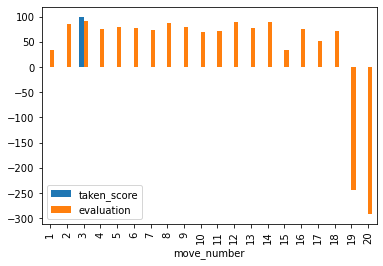

In [187]:
moves[['taken_score','evaluation']].plot(kind="bar")

Cool! It's clear there are a few key moves. 14 is a minor mistake. 18 was a big blunder

In [188]:
def play_board(moves):
    #Adding this function to make investigating easier
    taken_pieces=[]
    board=chess.Board()
    for san in moves:
        parsed_san=board.parse_san(san)
        taken=board.piece_at(parsed_san.to_square)
        if taken:
            taken_pieces.append(taken.__str__())
        move=board.push_san(san)
    return board,taken_pieces

def build_stored_game_analysis_smart_dumb(game, move_number):
    row={}
    row['move_number']=move_number
    board,row['taken']=play_board(game['moves'][:move_number])

    row['invalid']=bool(board.promoted) or bool(board.outcome())
    stockfish_good.set_fen_position(board.fen())
    evaluation=stockfish_good.get_evaluation()
    row['smart_evaluation']=evaluation['value']
    
    stockfish_bad.set_fen_position(board.fen())
    evaluation=stockfish_bad.get_evaluation()
    row['dumb_evaluation']=evaluation['value']
    
    
    row['taken_score']=sum([piece_scores.get(p) for p in row['taken']])*100
    row['fen']=board.fen()
    row['url']=game['headers'].get("_others",{}).get("LichessURL","")+f"#{move_number}"
    try:
        row['last_move']=san
    except:
        print(game)
        row['invalid']=True
    return row
row=build_stored_game_analysis_smart_dumb(game, 20)
row

{'move_number': 20,
 'taken': ['p', 'P'],
 'invalid': False,
 'smart_evaluation': -292,
 'dumb_evaluation': -12,
 'taken_score': 0,
 'fen': 'r2qkb1r/pp2pppp/1np2n2/8/2NP1Bb1/2N2Q2/PPP2PPP/2KR1B1R w kq - 10 11',
 'url': 'https://lichess.org/WbgBrAHb#20',
 'last_move': 'e4d5'}

Our "dumb_evaluation" still doesn't know it lost. Let's take a look

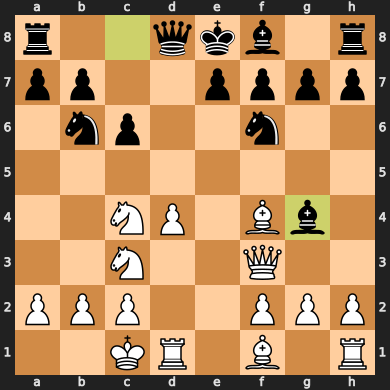

In [190]:
play_board(game['moves'][:20])[0]

Dumb might be too dumb. We'll increase the move number and plot it to see when the dumb stockfish gets it.

In [191]:
rows=[]
for move_number in tqdm.tqdm(range(1,30+1)):
    if move_number>len(game['moves']):
        break
    rows.append(build_stored_game_analysis_smart_dumb(game, move_number))
moves=pd.DataFrame(rows).set_index("move_number")
moves

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 26/30 [00:46<00:07,  1.79s/it]


,taken,invalid,smart_evaluation,dumb_evaluation,taken_score,fen,url,last_move
move_number,,,,,,,,
1,[],False,33,25,0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,https://lichess.org/WbgBrAHb#1,e4d5
2,[],False,86,84,0,rnbqkbnr/ppp1pppp/8/3p4/4P3/8/PPPP1PPP/RNBQKBN...,https://lichess.org/WbgBrAHb#2,e4d5
3,[p],False,92,67,100,rnbqkbnr/ppp1pppp/8/3P4/8/8/PPPP1PPP/RNBQKBNR ...,https://lichess.org/WbgBrAHb#3,e4d5
4,"[p, P]",False,75,153,0,rnb1kbnr/ppp1pppp/8/3q4/8/8/PPPP1PPP/RNBQKBNR ...,https://lichess.org/WbgBrAHb#4,e4d5
5,"[p, P]",False,80,175,0,rnb1kbnr/ppp1pppp/8/3q4/8/2N5/PPPP1PPP/R1BQKBN...,https://lichess.org/WbgBrAHb#5,e4d5
6,"[p, P]",False,78,807,0,rnb1kbnr/ppp1pppp/3q4/8/8/2N5/PPPP1PPP/R1BQKBN...,https://lichess.org/WbgBrAHb#6,e4d5
7,"[p, P]",False,73,97,0,rnb1kbnr/ppp1pppp/3q4/8/3P4/2N5/PPP2PPP/R1BQKB...,https://lichess.org/WbgBrAHb#7,e4d5
8,"[p, P]",False,87,838,0,rnb1kb1r/ppp1pppp/3q1n2/8/3P4/2N5/PPP2PPP/R1BQ...,https://lichess.org/WbgBrAHb#8,e4d5
9,"[p, P]",False,79,93,0,rnb1kb1r/ppp1pppp/3q1n2/8/3P4/2N2N2/PPP2PPP/R1...,https://lichess.org/WbgBrAHb#9,e4d5


<AxesSubplot:xlabel='move_number'>

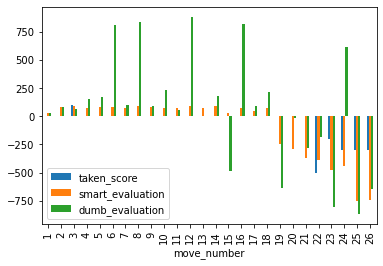

In [160]:
moves[['taken_score','smart_evaluation','dumb_evaluation']].plot(kind="bar")

Dumb stockfish looks way too overconfident. Thought it won at move 6! And then was all over the board.   
  
The best agreement appears to be at move 19

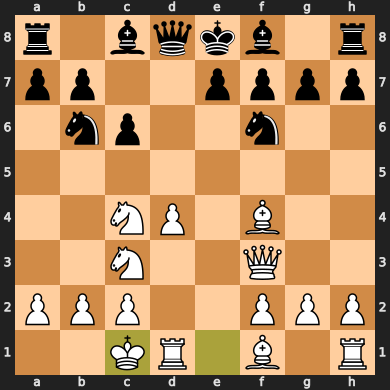

In [162]:
play_board(game['moves'][:19])[0]

This game looks to be lost be a quick thinking queen's side castle. A tricky position in quick games because it changes things so much.  
  
In my own play I generally miss how powerful the rook becomes by a King side castle. In this game the opposite happened.

For curiousity sake let's look at move 24 and try to understand why dumb stockfish liked it so much


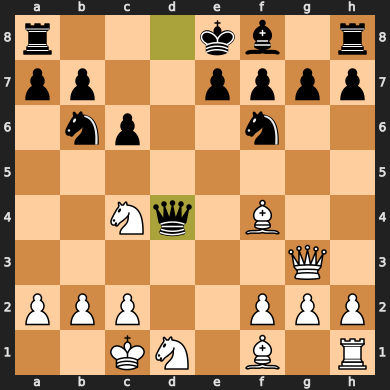

In [163]:
play_board(game['moves'][:24])[0]

I'm not seeing it. Let's see if we can replicate it

In [166]:
board,taken=play_board(game['moves'][:24])

stockfish_bad.set_fen_position(board.fen())
evaluation=stockfish_bad.get_evaluation()
evaluation,stockfish_bad.get_best_move()

({'type': 'cp', 'value': 615}, 'f4e3')

Hmm that really doesn't do much. Dumb stockfish may be too dumb

In [167]:
stockfish_bad.get_top_moves()#can be used to create an AI

[{'Move': 'f4e5', 'Centipawn': 74, 'Mate': None},
 {'Move': 'c4d2', 'Centipawn': -307, 'Mate': None},
 {'Move': 'c4b6', 'Centipawn': -360, 'Mate': None},
 {'Move': 'f4e3', 'Centipawn': -373, 'Mate': None},
 {'Move': 'c2c3', 'Centipawn': -426, 'Mate': None}]

# Further Project Ideas
I hope you now feel like you have the groundwork needed to do your own analysis from stored chess game databases.  
  
- If you are interested in detecting deciding points in games I would recommend simply running smart stockfish and detecting major changes relative to the prior position.  
- Look at "splits". Number of blunders by opening. Win rates by opening. Etc. 
- Consider pulling in all games from Lichess and doing some stratified samples to compare themes in different skill brackets.  
- To replicate something like chess.com's game analysis you can work with a few different Stockfish engines running at various skill levels. Find one's that correspond to blunders, mistakes, and inaccuracies when compared against Smart stockfish as the gold standard. You really don't need the different skill levels, simple deviation relative to the old position will do but I think it will help with richer analysis on types of blunders
- To create chess engines with personality I'd recommend looking into stockfish.get_top_moves. Use this and create a way to structure moves by style. For example give one move that trades a piece with lower value (say 2 pawns for a bishop). Bias that evaluation stronger compared to true Stockfish